In [1]:
"""Backend supported: pytorch, paddle, jax

Implementation of the linear elasticity 2D example in paper https://doi.org/10.1016/j.cma.2021.113741.
References:
    https://github.com/sciann/sciann-applications/blob/master/SciANN-Elasticity/Elasticity-Forward.ipynb.
"""

import deepxde as dde
import numpy as np
import time
import os
import argparse
import jax
import jax.numpy as jnp
from scipy.interpolate import RegularGridInterpolator


Using backend: jax
Other supported backends: tensorflow.compat.v1, tensorflow, pytorch, paddle.
paddle supports more examples now and is recommended.
Enable just-in-time compilation with XLA.



In [164]:



n_iter = 1000
log_every = 100
available_time = 0
log_output_fields = {0: 'Ux', 1: 'Uy', 2: 'Sxx', 3: 'Syy', 4: 'Sxy'}
net_type = 'spinn'
bc_type = 'hard'
mlp = 'mlp'
n_DIC = 6
noise_ratio = 0
lr = 0.001
u_0 = 1e-4
loss_weights = [1,1,1,1,1]

save_model = True

In [320]:
#%%
if net_type == "spinn":
    dde.config.set_default_autodiff("forward")

x_max = 2.0
y_max = 2.0
E = 210e3  # Young's modulus
nu = 0.3  # Poisson's ratio

lmbd = E * nu / ((1 + nu) * (1 - 2 * nu))  # Lame's first parameter
mu = E / (2 * (1 + nu))  # Lame's second parameter

# Load
pstress = 1.0


sin = dde.backend.sin
cos = dde.backend.cos
stack = dde.backend.stack




# Load geometry mapping
nx=100
ny=100
dir_path = r"."
Xp = np.loadtxt(os.path.join(dir_path, f"plate_hole_quarter_{nx}x{ny}.txt"))

# Interpolate mapping
X_map_points = Xp[:, 0].reshape((ny, nx)).T
Y_map_points = Xp[:, 1].reshape((ny, nx)).T

def coordMap(x, padding=1e-6, nx=nx, ny=ny, X_map_points=X_map_points, Y_map_points=Y_map_points):
    x_pos = x[0]/x_max*(nx-1)*(1-2*padding) + padding
    y_pos = x[1]/y_max*(ny-1)*(1-2*padding) + padding

    x_mapped = jax.scipy.ndimage.map_coordinates(X_map_points, [x_pos, y_pos], order=1, mode='nearest')
    y_mapped = jax.scipy.ndimage.map_coordinates(Y_map_points, [x_pos, y_pos], order=1, mode='nearest')

    return jnp.stack((x_mapped, y_mapped), axis=0)

def tensMap(tens, x):
    J = jax.jacobian(coordMap)(x)
    J_inv = jnp.linalg.inv(J)
    return tens @ J_inv

def calcNormal(x):
    n = jnp.array([-1, 0])
    n_mapped = tensMap(n, x)
    return n_mapped/jnp.linalg.norm(n_mapped)
    

# Load solution
n_mesh_x = 100
n_mesh_y = 100

data = np.loadtxt(os.path.join(dir_path, f"fem_solution_{n_mesh_x}x{n_mesh_y}.dat"))
X_val = data[:, :2]
u_val = data[:, 2:4]
stress_val = data[:, 7:10]

solution_val = np.hstack((u_val, stress_val))

# Interpolate solution
x_grid = np.linspace(0, x_max, n_mesh_x)
y_grid = np.linspace(0, y_max, n_mesh_y)

interpolators = []
for i in range(solution_val.shape[1]):
    interp = RegularGridInterpolator((x_grid, y_grid), solution_val[:, i].reshape(n_mesh_y, n_mesh_x).T)
    interpolators.append(interp)

def solution_fn(x):
    x_mesh = [x_.reshape(-1) for x_ in jnp.meshgrid(x[:, 0], x[:, 1], indexing="ij")]
    x = stack(x_mesh, axis=-1)
    # x = jax.vmap(coordMap)(x)
    return np.array([interp((x[:,0], x[:,1])) for interp in interpolators]).T

geom = dde.geometry.Rectangle([0, 0], [x_max, y_max])

def HardBC(x, f):
    x_mesh = [x_.ravel() for x_ in jnp.meshgrid(x[:, 0], x[:, 1], indexing="ij")]
    x = stack(x_mesh, axis=-1)
    x_mapped = jax.vmap(coordMap)(x)

    Ux = f[:, 0] * x_mapped[:, 0]*(y_max - x[:, 1])*u_0
    Uy = f[:, 1] * x[:, 1]*u_0

    mask = jnp.logical_and(x[:,0]==0, x_mapped[:,1]<=0.5)

    normal_mapped = jax.vmap(calcNormal)(x)
    Tx = normal_mapped[:, 0]
    Ty = normal_mapped[:, 1]

    # Tx = jnp.where(mask, Tx, jnp.ones_like(Tx)) 
    # Ty = jnp.where(mask, Ty, jnp.ones_like(Ty))
    pstress_array = pstress * jnp.maximum(x_mapped[:, 1]-0.5,0)/(x_max-0.5)

    distCorner = (x[:, 0] + jnp.maximum(x_mapped[:, 1]-0.5,0))
    Sbc = f[:, 5]*(x_max - x[:, 0])*x_mapped[:, 0] * x[:, 1] * (x_max - x[:, 1]) 
    # Sbc = jnp.ones_like(f[:, 2])

    # Sbc = jnp.where(mask,  f[:, 3], jnp.zeros_like(f[:, 3]))

    Sxx = f[:, 2] * (x_max - x[:, 0]) * distCorner + Sbc*Ty**2
    Syy = f[:, 3] * (y_max - x[:, 1]) * distCorner + pstress_array + Sbc*Tx**2
    Sxy = f[:, 4] *x_mapped[:, 0] * x[:, 1] * (x_max - x[:, 0]) * distCorner - Sbc*(Tx*Ty)

    return stack((Ux, Uy, Sxx, Syy, Sxy), axis=1)


def jacobian(f, x, i, j):
    if dde.backend.backend_name == "jax":
        return dde.grad.jacobian(f, x, i=i, j=j)[0]  
    else:
        return dde.grad.jacobian(f, x, i=i, j=j)


def pde(x, f):
    # x_mesh = jnp.meshgrid(x[:,0].ravel(), x[:,0].ravel(), indexing='ij')
    if net_type == "spinn":
        x_mesh = [x_.reshape(-1) for x_ in jnp.meshgrid(x[:, 0], x[:, 1], indexing="ij")]
        x = stack(x_mesh, axis=-1)
    x = jax.vmap(coordMap)(x)

    E_xx = jacobian(f, x, i=0, j=0) 
    E_yy = jacobian(f, x, i=1, j=1)
    E_xy = 0.5 * (jacobian(f, x, i=0, j=1) + jacobian(f, x, i=1, j=0))

    S_xx = E_xx * (2 * mu + lmbd) + E_yy * lmbd
    S_yy = E_yy * (2 * mu + lmbd) + E_xx * lmbd
    S_xy = E_xy * 2 * mu

    Sxx_x = jacobian(f, x, i=2, j=0)
    Syy_y = jacobian(f, x, i=3, j=1)
    Sxy_x = jacobian(f, x, i=4, j=0)
    Sxy_y = jacobian(f, x, i=4, j=1)

    momentum_x = Sxx_x + Sxy_y 
    momentum_y = Sxy_x + Syy_y 

    if dde.backend.backend_name == "jax":
        f = f[0]  # f[1] is the function used by jax to compute the gradients

    stress_x = S_xx - f[:, 2:3]
    stress_y = S_yy - f[:, 3:4]
    stress_xy = S_xy - f[:, 4:5]

    return [momentum_x, momentum_y, stress_x, stress_y, stress_xy]

# Integral stress BC
n_integral = 100
x_integral = np.linspace(0, x_max, n_integral)
# y_integral = np.linspace(0, y_max, n_integral)
y_integral = np.concatenate((np.linspace(0, y_max*0.4, int(n_integral/2)), np.linspace(y_max*0.6, y_max, int(n_integral/2))))
integral_points = np.stack((x_integral, y_integral), axis=1)

def integral_stress(inputs, outputs, X):
    x_grid = [x_.reshape(-1) for x_ in jnp.meshgrid(inputs[:, 0], inputs[:, 1], indexing="ij")]
    x_grid = stack(x_grid, axis=-1)
    x_mesh = jax.vmap(coordMap)(x_grid)[:,0].reshape((inputs.shape[0], inputs.shape[0]))

    Syy = outputs[:, 3:4].reshape(x_mesh.shape)
    return jnp.trapezoid(Syy, x_mesh, axis=0)

Integral_BC = dde.PointSetOperatorBC(integral_points, pstress*x_max, integral_stress)

bcs = []# [Integral_BC]
num_boundary = 0

# if n_DIC:
#     bcs += [measure_Ux, measure_Uy]

# if bc_type == "soft":
#     bcs += [
#         sxx_right_bc,
#         uy_bottom_bc,
#         ux_left_bc,
#     ]
#     num_boundary = 64 if net_type == "spinn" else 500


def get_num_params(net, input_shape=None):
    if dde.backend.backend_name == "pytorch":
        return sum(p.numel() for p in net.parameters())
    elif dde.backend.backend_name == "paddle":
        return sum(p.numpy().size for p in net.parameters())
    elif dde.backend.backend_name == "jax":
        if input_shape is None:
            raise ValueError("input_shape must be provided for jax backend")
        import jax
        import jax.numpy as jnp

        rng = jax.random.PRNGKey(0)
        return sum(
            p.size for p in jax.tree.leaves(net.init(rng, jnp.ones(input_shape)))
        )


activation = "tanh"
initializer = "Glorot uniform"
optimizer = "adam"
h_plot = 0.02
if net_type == "spinn":
    layers = [2, 64, 64, 64, 128, 6]
    net = dde.nn.SPINN(layers, activation, initializer, mlp)
    num_point = 10000
    total_points = num_point**2 + num_boundary**2
    num_params = get_num_params(net, input_shape=layers[0])
    x_plot = np.linspace(0,x_max,100)
    y_plot = np.linspace(0,y_max,100)
    X_plot = np.stack((x_plot, y_plot), axis=1)

else:
    layers = [2, [40] * 5, [40] * 5, [40] * 5, [40] * 5, 5]
    net = dde.nn.PFNN(layers, activation, initializer)
    num_point = 500
    total_points = num_point + num_boundary
    num_params = get_num_params(net, input_shape=layers[0])
    X_mesh = np.meshgrid(
        np.linspace(0, x_max, int(x_max/h_plot)),
        np.linspace(0, y_max, int(y_max/h_plot)),
        indexing="ij",
    )
    X_plot = np.stack((X_mesh[0].ravel(), X_mesh[1].ravel()), axis=1)

num_test = 10000

data = dde.data.PDE(
    geom,
    pde,
    bcs,
    num_domain=num_point,
    num_boundary=num_boundary,
    solution=solution_fn,
    num_test=num_test,
    is_SPINN=net_type == "spinn",
)

if bc_type == "hard":
    net.apply_output_transform(HardBC)


# results_path = [r"./forward",r"/mnt/d/phd/SPIQ/deep_notched/forward"][1]
# folder_name = f"{net_type}_{available_time if available_time else n_iter}{'min' if available_time else 'iter'}"

# # Check if any folders with the same name exist
# existing_folders = [f for f in os.listdir(results_path) if f.startswith(folder_name)]

# # If there are existing folders, find the highest number suffix
# if existing_folders:
#     suffixes = [int(f.split("-")[-1]) for f in existing_folders if f != folder_name]
#     if suffixes:
#         max_suffix = max(suffixes)
#         folder_name = f"{folder_name}-{max_suffix + 1}"
#     else:
#         folder_name = f"{folder_name}-1"

# # Create the new folder
# new_folder_path = os.path.join(results_path, folder_name)
# if not os.path.exists(new_folder_path):
#     os.makedirs(new_folder_path)

# save_model_path = os.path.join(new_folder_path, "model") if save_model else None

# callbacks = [dde.callbacks.Timer(available_time)] if available_time else []

# for i, field in log_output_fields.items():
#     callbacks.append(dde.callbacks.OperatorPredictor(X_plot, lambda x, output, i=i: output[0][:, i], period=log_every, filename=os.path.join(new_folder_path, f"{field}_history.dat")))

model = dde.Model(data, net)
model.compile(optimizer, lr=lr, metrics=["l2 relative error"], loss_weights=loss_weights)

# n_iter = 1000
# log_every = 10
# save_model_path = "/home/dbey/SPIQ/deep_notched/test_model"
# losshistory, train_state = model.train(
#     iterations=n_iter, callbacks=callbacks, display_every=log_every
# )


Set the default automatic differentiation to forward mode.
Compiling model...
'compile' took 0.107602 s



In [321]:
n_iter = 10000
log_every = 100
save_model_path = "/home/dbey/SPIQ/deep_notched/test_model"
losshistory, train_state = model.train(
    iterations=n_iter, display_every=log_every
)


Training model...

0         [3.52e-01, 1.06e+00, 1.59e+01, 5.29e+00, 2.69e+00]    [3.52e-01, 1.06e+00, 1.59e+01, 5.29e+00, 2.69e+00]    [8.78e-01]    
100       [2.16e-03, 2.72e-01, 9.95e-03, 1.86e-02, 5.33e-03]    [2.16e-03, 2.72e-01, 9.95e-03, 1.86e-02, 5.33e-03]    [7.46e-01]    
200       [5.31e-03, 1.69e-01, 1.13e-02, 2.31e-02, 7.58e-03]    [5.31e-03, 1.69e-01, 1.13e-02, 2.31e-02, 7.58e-03]    [6.47e-01]    
300       [5.71e-03, 1.48e-01, 7.02e-03, 1.69e-02, 1.08e-02]    [5.71e-03, 1.48e-01, 7.02e-03, 1.69e-02, 1.08e-02]    [6.07e-01]    
400       [6.29e-03, 1.31e-01, 5.42e-03, 1.36e-02, 1.36e-02]    [6.29e-03, 1.31e-01, 5.42e-03, 1.36e-02, 1.36e-02]    [5.79e-01]    
500       [6.32e-03, 1.14e-01, 4.57e-03, 1.01e-02, 1.21e-02]    [6.32e-03, 1.14e-01, 4.57e-03, 1.01e-02, 1.21e-02]    [5.42e-01]    
600       [6.37e-03, 9.44e-02, 3.93e-03, 1.27e-02, 1.06e-02]    [6.37e-03, 9.44e-02, 3.93e-03, 1.27e-02, 1.06e-02]    [4.97e-01]    
700       [6.49e-03, 8.44e-02, 3.77e-03, 1.63e-02,

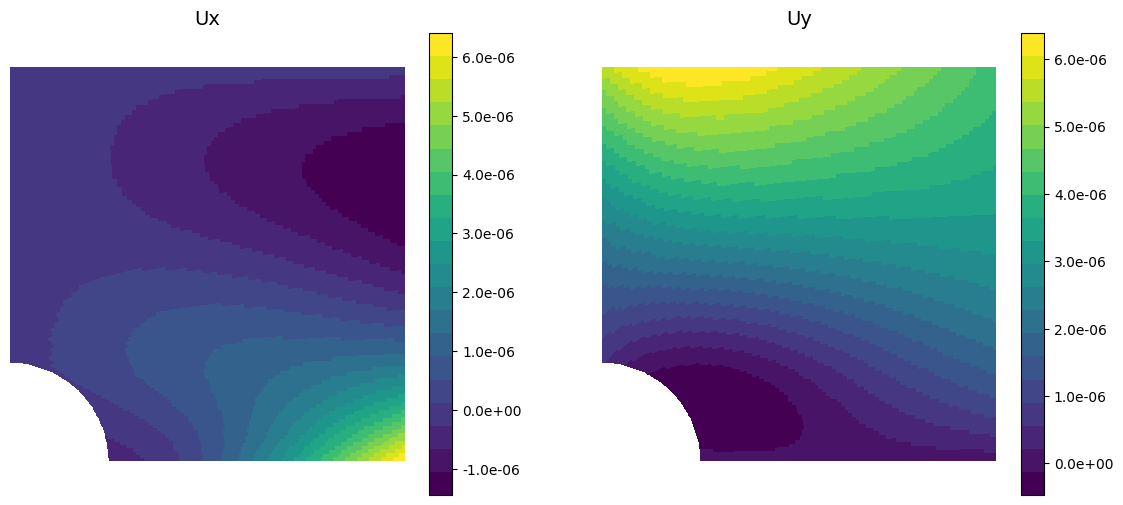

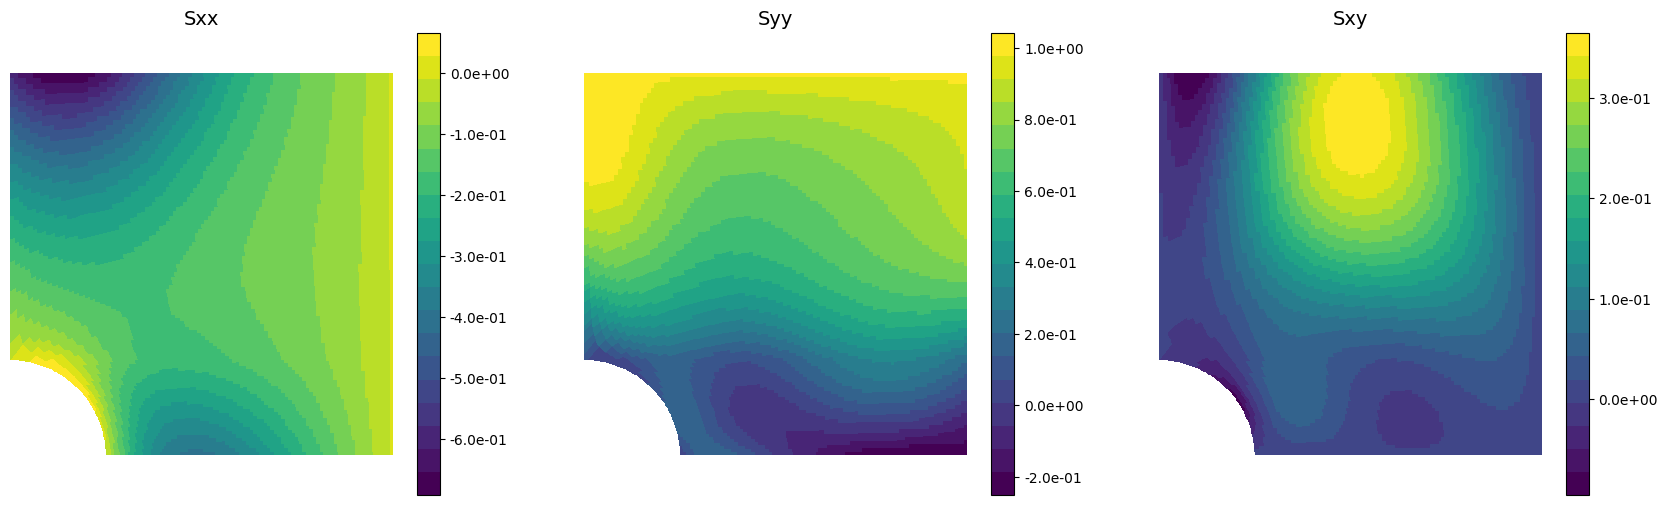

In [322]:
import matplotlib.colors as colors
import os
from scipy.interpolate import RegularGridInterpolator
import matplotlib.ticker as ticker
import matplotlib.transforms as mtransforms
import matplotlib.pyplot as plt

R=0.5
L=2.0
ngrid=100

x_bcs = np.linspace(0,L,ngrid)
y_bcs = np.linspace(0,L,ngrid)
X_input_bcs = np.stack((x_bcs, y_bcs), axis=1)
F_bcs = model.predict(X_input_bcs)

x_center = np.linspace(0,L,2*ngrid)[1:-1:2]
y_center = np.linspace(0,L,2*ngrid)[1:-1:2]
X_input = np.stack((x_center, y_center), axis=1)

x_edge = np.linspace(0,x_max,ngrid)
y_edge = np.linspace(0,L,ngrid)

Xgrid, Ygrid = np.meshgrid(x_edge, y_edge, indexing="ij")
Xmesh = jax.vmap(coordMap)(np.stack((Xgrid.ravel(), Ygrid.ravel()), axis=1))
Xmesh, Ymesh = Xmesh[:,0].reshape(Xgrid.shape), Xmesh[:,1].reshape(Ygrid.shape)

F = model.predict(X_input)
Ux = F[:, 0:1].reshape(len(x_center), len(y_center))
Uy = F[:, 1].reshape(len(x_center), len(y_center))
Sxx = F[:, 2].reshape(len(x_center), len(y_center))
Syy = F[:, 3].reshape(len(x_center), len(y_center))
Sxy = F[:, 4].reshape(len(x_center), len(y_center))


cmap = plt.get_cmap('viridis')
num_colors = 20
color_values = [cmap(i) for i in np.linspace(0, 1, num_colors)]
cmap = colors.ListedColormap(color_values)

def pcolor_plot(AX, X, Y, C, title,colormap=cmap,norm=None):

    # X, Y = compute_edges_from_nodes(X, Y)
    im = AX.pcolormesh(X, Y, C, cmap=colormap,shading='auto',norm=norm, edgecolors='none', linewidth=0.01)

    AX.axis("equal")
    AX.axis("off")
    AX.set_title(title, fontsize=14)
    return im

fig, axs = plt.subplots(1, 2, figsize=(14, 6))
im = pcolor_plot(axs[0], Xmesh, Ymesh, Ux, "Ux")
fig.colorbar(im, ax=axs[0], format=ticker.FuncFormatter(lambda x, _: f"{x:.1e}"))
im = pcolor_plot(axs[1], Xmesh, Ymesh, Uy, "Uy")
fig.colorbar(im, ax=axs[1], format=ticker.FuncFormatter(lambda x, _: f"{x:.1e}"))

fig, axs = plt.subplots(1, 3, figsize=(21, 6))
im = pcolor_plot(axs[0], Xmesh, Ymesh, Sxx, "Sxx")
fig.colorbar(im, ax=axs[0], format=ticker.FuncFormatter(lambda x, _: f"{x:.1e}"))
im = pcolor_plot(axs[1], Xmesh, Ymesh, Syy, "Syy")
fig.colorbar(im, ax=axs[1], format=ticker.FuncFormatter(lambda x, _: f"{x:.1e}"))
im = pcolor_plot(axs[2], Xmesh, Ymesh, Sxy, "Sxy")
fig.colorbar(im, ax=axs[2], format=ticker.FuncFormatter(lambda x, _: f"{x:.1e}"))




/tmp/ipykernel_11008/3108479120.py:28: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  axs[ind[0]][ind[1]].set_ylim([min(y_bc), max(y_bc)])
/tmp/ipykernel_11008/3108479120.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_11008/3108479120.py:36: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  axs[ind[0]][ind[1]].set_xlim([min(x_bc), max(x_bc)])


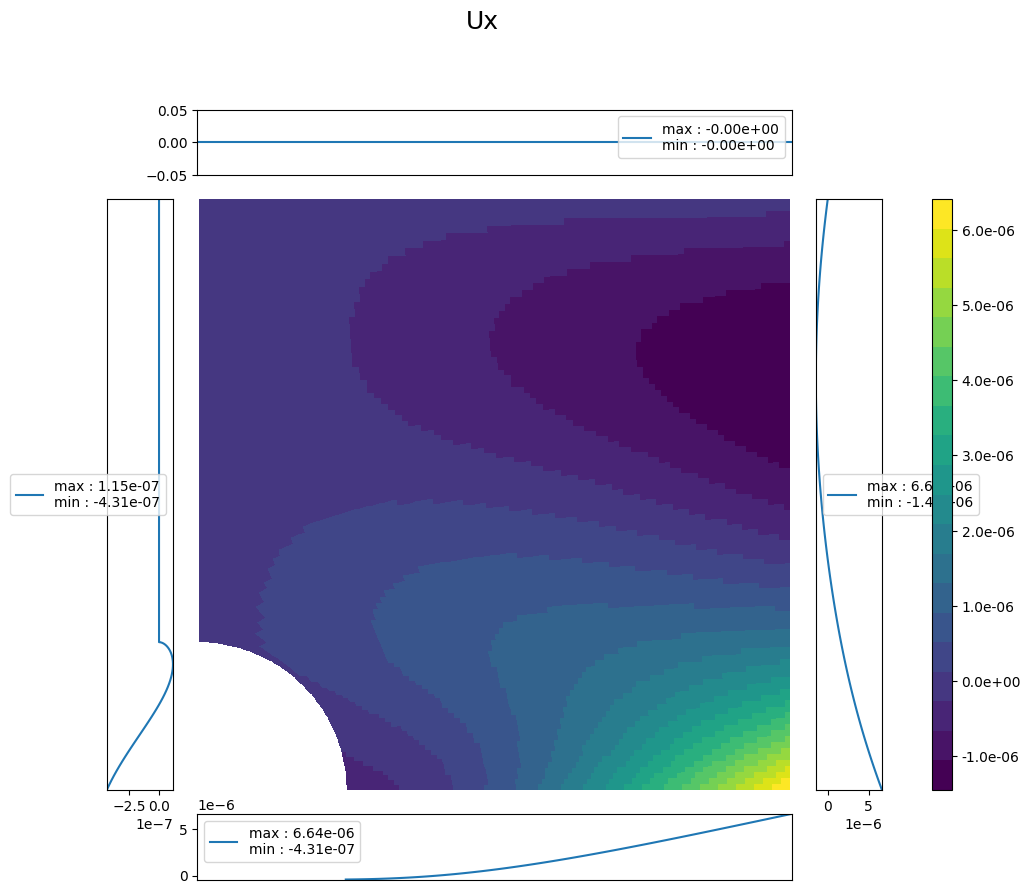

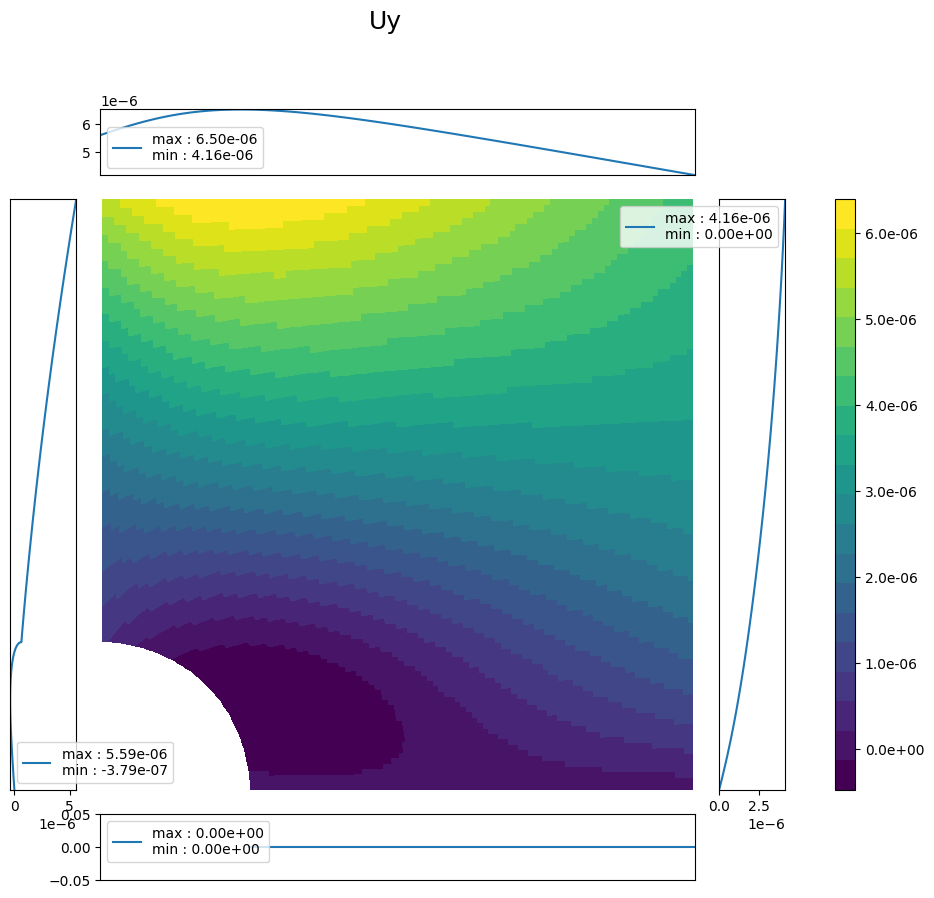

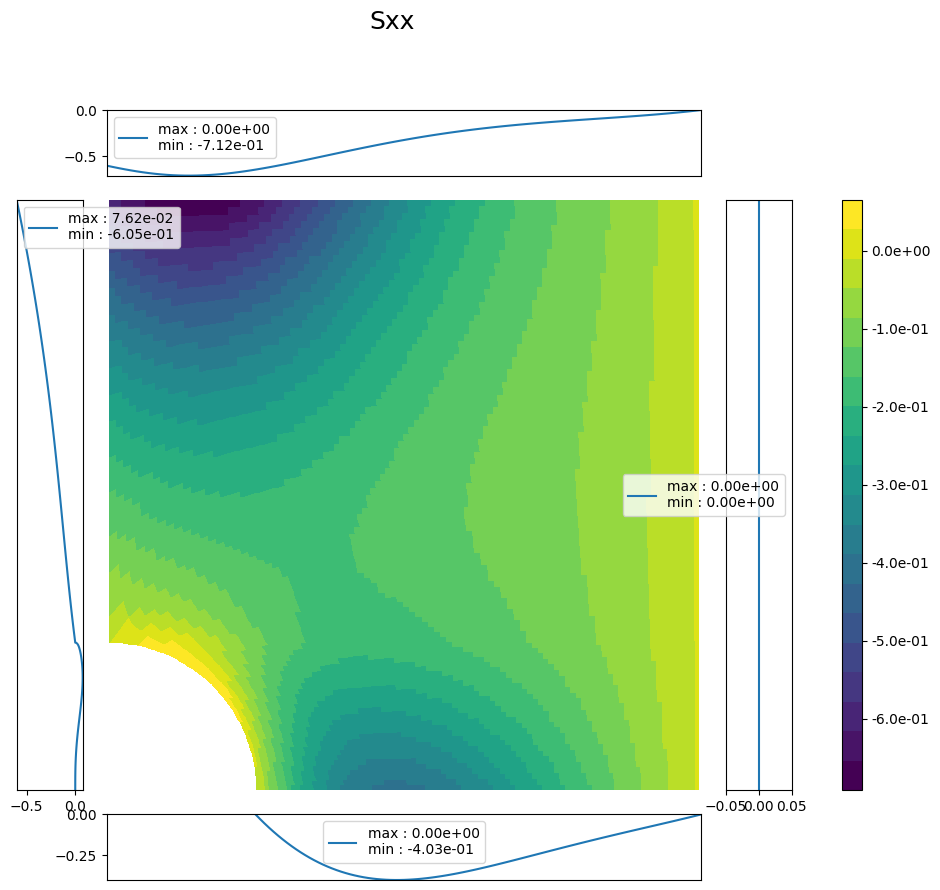

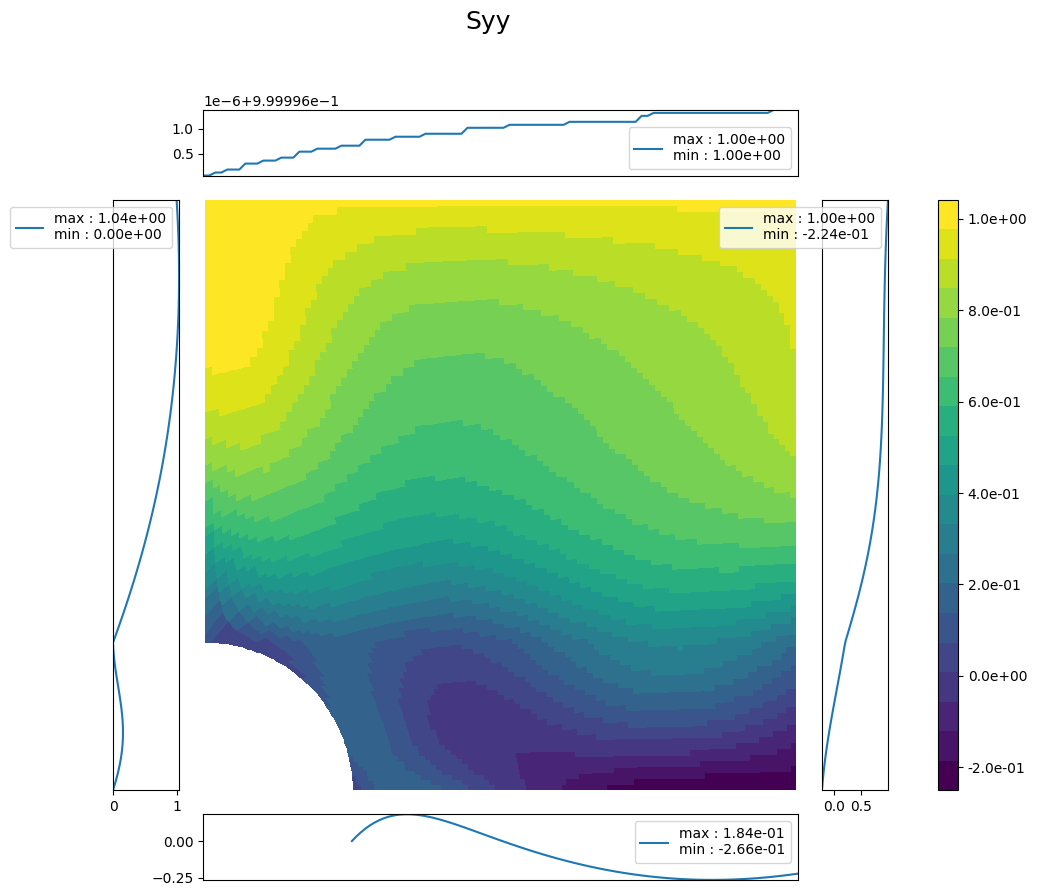

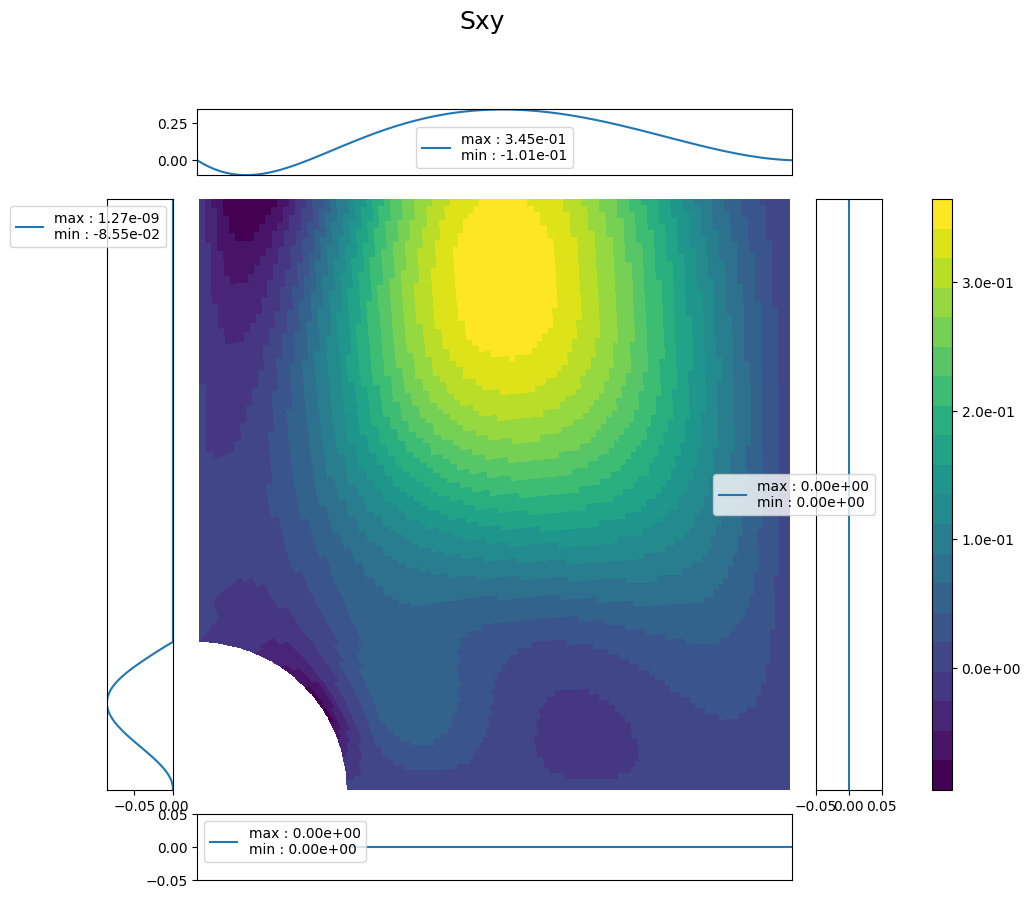

In [323]:

def plot_boundary(F, F_bc, X, Y, title, axs):
    x_top = X[:,-1]
    x_bottom = X[:,0]
    y_left = Y[0,:]
    y_right = Y[-1,:]

    F_top = F_bc[-1,:]
    F_bottom = F_bc[0,:]
    F_left = F_bc[:,0]
    F_right = F_bc[:,-1]

    x_bcs = [x_top, x_bottom, F_left, F_right] 
    y_bcs = [F_top, F_bottom, y_left, y_right]

    index_bcs = [[0,1],[2,1],[1,0],[1,2]]

    axs[0][0].axis("off")
    axs[0][2].axis("off")
    axs[2][0].axis("off")
    axs[2][2].axis("off")

    for i, (x_bc, y_bc, ind) in enumerate(zip(x_bcs, y_bcs, index_bcs)):
        # axs[ind[0]][ind[1]].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{x:.1e}"))
        if i<2:
            axs[ind[0]][ind[1]].plot(x_bc, y_bc, label=f"max : {np.max(y_bc):.2e}\nmin : {np.min(y_bc):.2e}")
            axs[ind[0]][ind[1]].xaxis.set_visible(False)
            axs[ind[0]][ind[1]].set_xlim([0, 2.0])
            axs[ind[0]][ind[1]].set_ylim([min(y_bc), max(y_bc)])
            #log scale
            # axs[ind[0]][ind[1]].set_yscale('log')

        else:
            axs[ind[0]][ind[1]].plot(x_bc, y_bc, label=f"max : {np.max(x_bc):.2e}\nmin : {np.min(x_bc):.2e}")
            axs[ind[0]][ind[1]].yaxis.set_visible(False)
            axs[ind[0]][ind[1]].set_ylim([0, 2.0])
            axs[ind[0]][ind[1]].set_xlim([min(x_bc), max(x_bc)])
            #log scale
            # axs[ind[0]][ind[1]].set_xscale('log')
        axs[ind[0]][ind[1]].legend()
            
    im = pcolor_plot(axs[1][1], X, Y, F, None)
    axs[1][1].set_zorder(-1)
    pos = axs[1][2].get_position()
    cax = fig.add_axes([pos.width + pos.x0 +0.05, pos.y0, 0.02, pos.height])
    fig.colorbar(im, cax=cax, format=ticker.FuncFormatter(lambda x, _: f"{x:.1e}"))
    plt.tight_layout()
    plt.suptitle(title, fontsize=18)


fields = [Ux, Uy, Sxx, Syy, Sxy]
fields_bc = [F_bcs[:,i].reshape(len(x_bcs), len(y_bcs)).T for i in range(5)]
# fields_bc = fields_bc[-1:]
titles = ["Ux", "Uy", "Sxx", "Syy", "Sxy"]

for i,title in enumerate(titles):
    field = fields[i]
    field_bc = fields_bc[i]
    fig, axs = plt.subplots(3, 3, figsize=(10, 10), height_ratios=[0.1, 0.9, 0.1], width_ratios=[0.1, 0.9, 0.1], gridspec_kw={"hspace": 0.1, "wspace": 0.1})
    plot_boundary(field, field_bc, Xmesh, Ymesh, title, axs)

# fig, axs = plt.subplots(3, 3, figsize=(10, 10), height_ratios=[0.1, 0.9, 0.1], width_ratios=[0.1, 0.9, 0.1], gridspec_kw={"hspace": 0.1, "wspace": 0.1})
# plot_boundary(Ux, Xmesh, Ymesh, "Ux", axs)



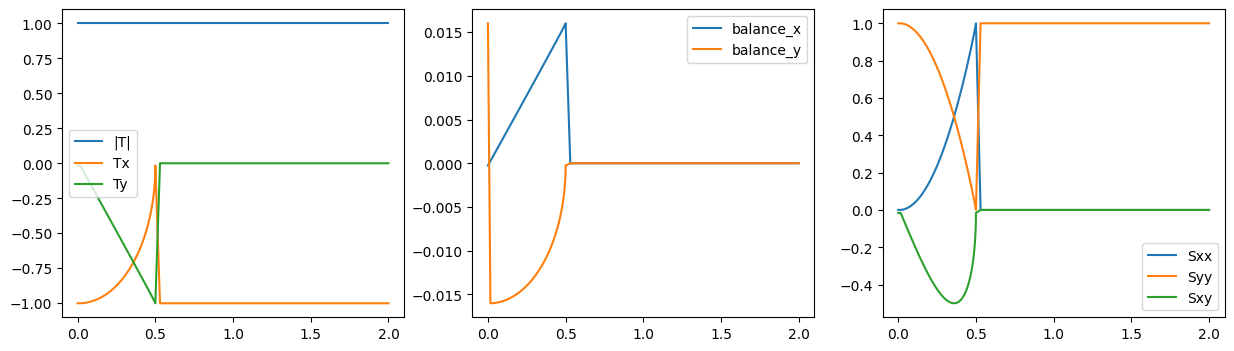

In [301]:
x_left = np.zeros(ngrid)
y_left = np.linspace(0, x_max, ngrid)
X_left = np.stack((x_left, y_left), axis=1)
X_left_mapped = jax.vmap(coordMap)(X_left)

Tx = [-X_left_mapped[i,0]/R if X_left_mapped[i,1] <= R+1e-6 else -1 for i in range(ngrid)]
Ty = [-X_left_mapped[i,1]/R if X_left_mapped[i,1] <= R+1e-6 else 0 for i in range(ngrid)] 

normal_mapped = jax.vmap(calcNormal)(X_left)
Tx_j, Ty_j = normal_mapped[:, 0], normal_mapped[:, 1]
# fig, ax = plt.subplots(figsize=(10, 10))
# plt.quiver(X_left_mapped[:,0], X_left_mapped[:,1], Tx, Ty, scale=7)
# plt.quiver(X_left_mapped[:,0], X_left_mapped[:,1], Tx_j, Ty_j, scale=7, color='r')


# plt.scatter(X_left_mapped[:,0], X_left_mapped[:,1], c=Tx, cmap='viridis', s=1)
# plt.gca().set_aspect('equal', adjustable='box')
# ax.set_xlim([-0.2, 0.55])

Tx, Ty = jnp.array(Tx), jnp.array(Ty)
Sbc_test = np.ones(Ty_j.shape)
Sxx_test = Sbc_test * Ty_j**2
Syy_test = Sbc_test * Tx_j**2
Sxy_test = -Sbc_test * Tx_j * Ty_j

balance_x_test = Sxx_test*Tx + Sxy_test*Ty 
balance_y_test = Sxy_test*Tx + Syy_test*Ty

fig, axs = plt.subplots(1, 3, figsize=(15, 4))
axs[0].plot(X_left_mapped[:,1],np.array(Tx_j)**2 + np.array(Ty_j)**2, label='|T|')
axs[0].plot(X_left_mapped[:,1],Tx_j, label='Tx')
axs[0].plot(X_left_mapped[:,1],Ty_j, label='Ty')
axs[0].legend()

axs[1].plot(X_left_mapped[:,1],balance_x_test, label='balance_x')
axs[1].plot(X_left_mapped[:,1],balance_y_test, label='balance_y')
axs[1].legend()

axs[2].plot(X_left_mapped[:,1],Sxx_test, label='Sxx')
axs[2].plot(X_left_mapped[:,1],Syy_test, label='Syy')
axs[2].plot(X_left_mapped[:,1],Sxy_test, label='Sxy')
# axs[2].plot(X_left_mapped[:,1],Sbc_test, label='Sbc')
axs[2].legend()


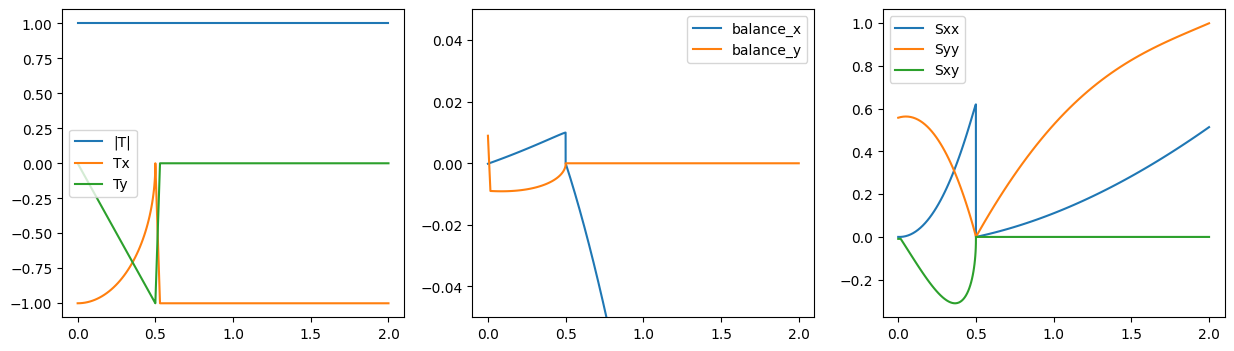

In [306]:
# fields_bc = [F_bcs[:,i].reshape(len(x_bcs), len(y_bcs)).T for i in range(6)]

Sxx_left = fields_bc[2][:,0]
Syy_left = fields_bc[3][:,0]
Sxy_left = fields_bc[4][:,0]
# Sbc_left = fields_bc[5][:,0]

balance_x = Sxx_left*Tx + Sxy_left*Ty 
balance_y = Sxy_left*Tx + Syy_left*Ty

fig, axs = plt.subplots(1, 3, figsize=(15, 4))
axs[0].plot(X_left_mapped[:,1],np.array(Tx)**2 + np.array(Ty)**2, label='|T|')
axs[0].plot(X_left_mapped[:,1],Tx, label='Tx')
axs[0].plot(X_left_mapped[:,1],Ty, label='Ty')
axs[0].legend()

axs[1].plot(X_left_mapped[:,1],balance_x, label='balance_x')
axs[1].plot(X_left_mapped[:,1],balance_y[:], label='balance_y')
axs[1].legend()
axs[1].set_ylim([-0.05, 0.05])

axs[2].plot(X_left_mapped[:,1],Sxx_left, label='Sxx')
axs[2].plot(X_left_mapped[:,1],Syy_left, label='Syy')
axs[2].plot(X_left_mapped[:,1],Sxy_left, label='Sxy')
# axs[2].plot(X_left_mapped[:,1],Sbc_left, label='Sbc')
axs[2].legend()

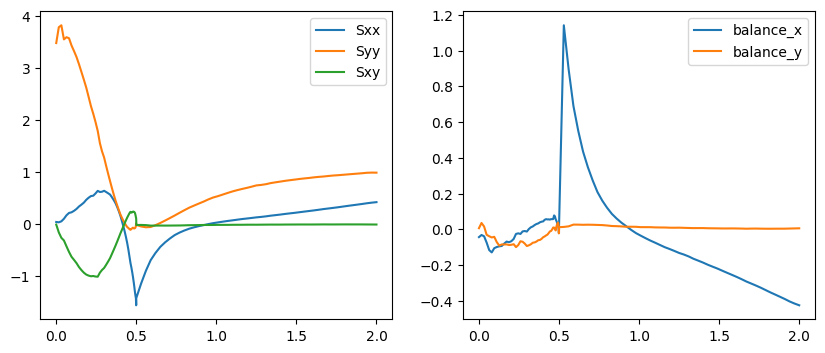

In [303]:

def solution_fn_flat(x):
    return np.array([interp((x[:,0], x[:,1])) for interp in interpolators]).T

x_left = np.zeros(ngrid)
y_left = np.linspace(0, x_max, ngrid)
X_left = np.stack((x_left, y_left), axis=1)
X_left_mapped = jax.vmap(coordMap)(X_left)

F_left_exact = solution_fn_flat(np.stack((x_left, y_left), axis=1))

balance_x = F_left_exact[:,2]*Tx + F_left_exact[:,4]*Ty
balance_y = F_left_exact[:,4]*Tx + F_left_exact[:,3]*Ty

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].plot(X_left_mapped[:,1],F_left_exact[:,2], label='Sxx')
axs[0].plot(X_left_mapped[:,1],F_left_exact[:,3], label='Syy')
axs[0].plot(X_left_mapped[:,1],F_left_exact[:,4], label='Sxy')
axs[0].legend()

axs[1].plot(X_left_mapped[:,1],balance_x, label='balance_x')
axs[1].plot(X_left_mapped[:,1],balance_y, label='balance_y')
axs[1].legend()

/tmp/ipykernel_11008/3108479120.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


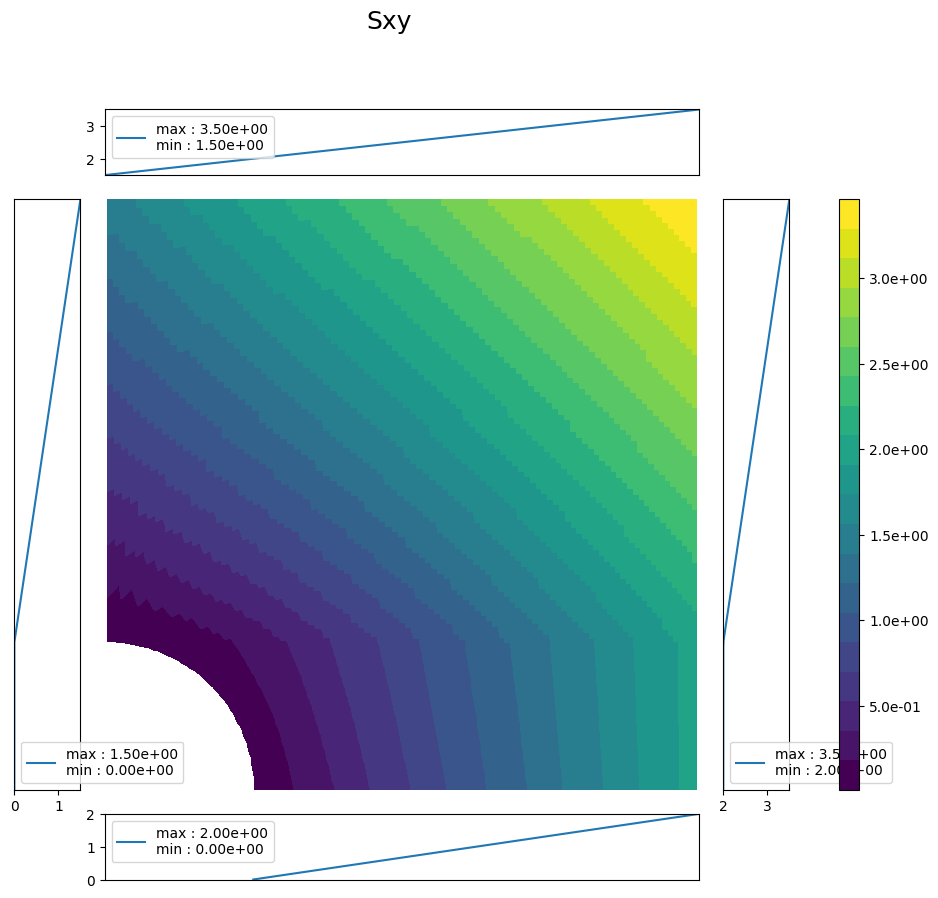

In [274]:
x_center_grid, y_center_grid = np.meshgrid(x_center, y_center, indexing="ij")
X_center_grid_mapped = jax.vmap(coordMap)(np.stack((x_center_grid.ravel(), y_center_grid.ravel()), axis=1))

x_bc_grid, y_bc_grid = np.meshgrid(x_bcs, y_bcs, indexing="ij")
distCorner = (x_center_grid+ np.maximum(X_center_grid_mapped[:,1].reshape(x_center_grid.shape)-0.5,0))
distCorner_bc = (x_bc_grid+ np.maximum(Ymesh-0.5,0)).T

fig, axs = plt.subplots(3, 3, figsize=(10, 10), height_ratios=[0.1, 0.9, 0.1], width_ratios=[0.1, 0.9, 0.1], gridspec_kw={"hspace": 0.1, "wspace": 0.1})
plot_boundary(distCorner, distCorner_bc, Xmesh, Ymesh, title, axs)


/tmp/ipykernel_11008/3108479120.py:28: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  axs[ind[0]][ind[1]].set_ylim([min(y_bc), max(y_bc)])
/tmp/ipykernel_11008/3108479120.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


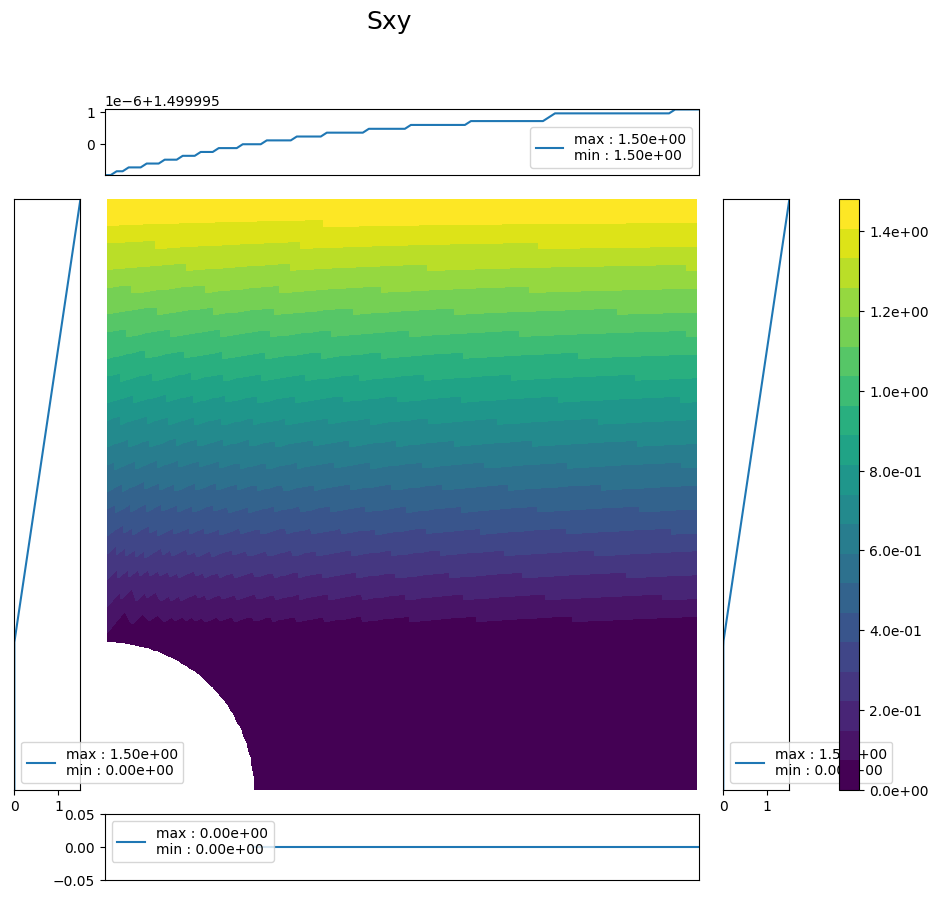

In [275]:
x_center_grid, y_center_grid = np.meshgrid(x_center, y_center, indexing="ij")
X_center_grid_mapped = jax.vmap(coordMap)(np.stack((x_center_grid.ravel(), y_center_grid.ravel()), axis=1))

x_bc_grid, y_bc_grid = np.meshgrid(x_bcs, y_bcs, indexing="ij")
distCorner = (jnp.maximum(X_center_grid_mapped[:,1].reshape(x_center_grid.shape)-0.5,0))
distCorner_bc = (jnp.maximum(Ymesh-0.5,0)).T

fig, axs = plt.subplots(3, 3, figsize=(10, 10), height_ratios=[0.1, 0.9, 0.1], width_ratios=[0.1, 0.9, 0.1], gridspec_kw={"hspace": 0.1, "wspace": 0.1})
plot_boundary(distCorner, distCorner_bc, Xmesh, Ymesh, title, axs)

In [130]:
X_center_grid_mapped.shape

(9801, 2)